<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Path Planning for a Simple Car](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.03-Path-Planning-for-a-Simple-Car.ipynb) | [Contents](toc.ipynb) | [Parameter Estimation](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/07.00-Parameter-Estimation.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.04-Soft-Landing-Apollo-11-on-the-Moon.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Soft Landing Apollo 11 on the Moon

Landing a rocket on the surface of a planet was once a staple of science fiction, and then realized in the 1960's through multiple manned and unmanned landings on the moon. It's hard to overestimate the degree to which these missions inspired a new generation 

<a title="NASA Michael Collins [Public domain], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Eagle_In_Lunar_Orbit_-_GPN-2000-001210.jpg"><img width="256" alt="Eagle In Lunar Orbit - GPN-2000-001210" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Eagle_In_Lunar_Orbit_-_GPN-2000-001210.jpg/256px-Eagle_In_Lunar_Orbit_-_GPN-2000-001210.jpg"></a>
NASA Michael Collins [Public domain]

**Rocket Landing Videos** (these never get old):

* [Apollo 11 Landing on the Moon, July 20, 1969](https://youtu.be/k_OD2V6fMLQ)
* [SpaceX Falcon Heavy Side Boosters Landing at Kennedy Space Center, February 6, 2018 ](https://youtu.be/u0-pfzKbh2k)
* [Blue Origin, November 24, 2014](https://youtu.be/9pillaOxGCo?t=103)

Inspired by these examples, this notebook uses Pyomo and a simple model of a rocket to compute a control policy for a soft landing. The parameters used correspond to the descent of the Apollo 11 Lunar Module to the moon on July 20, 1969.

## Required Installations



### Google Colab

The following cell installs the necessary packages and solvers on Google Colab. This installation must be done for each Google Colab session.

In [0]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q pyomo
    !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
    !unzip -o -q ipopt-linux64
    ipopt_executable = '/content/ipopt'

  ### MacOS
  
  On MacOS, replace the above cell with the following text to perform a one-time installation.
    
    !conda install -c conda-forge pyomo
    !conda install -c conda-forge ipopt
    ipopt_executiable = 'bin/ipopt'

### Windows PC

Pyomo can be installed by executing

    !pip install -q pyomo
    
into a Jupyter notebook cell. An ipopt binary executable is available from [ampl.com](https://ampl.com/products/solvers/open-source/).  More specific instructions for a one-tme installation on Windows PC will be forthcoming.  

## Python Initializations

In [0]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *
import numpy as np

## Version 1: Vertical Dynamics of a Rocket with Constant Mass

For a rocket with a mass $m$ in vertical flight at altitude $h$, a momentum balance yields the model

\begin{align*}
m\frac{d^2h}{dt^2} & = - m g + v_eu \\
\end{align*}

where $u$ is the mass flow of propellant and $v_e$ is the velocity of the exhaust relative to the rocket. In this first attempt at modeling and control we will neglect the change in rocket mass due to fuel burn.

<a title="LM_illustration_02.jpg: NASA Marshall Space Flight Center (NASA-MSFC)
derivative work: Adert [Public domain], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:LM_illustration_02-IT.png"><img width="256" alt="LM illustration 02-IT" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/LM_illustration_02-IT.png/256px-LM_illustration_02-IT.png"></a>

LM_illustration_02.jpg: NASA Marshall Space Flight Center (NASA-MSFC)derivative work: Adert [Public domain]

The complete Apollo lunar module was composed of descent and ascent stages, each containing a rocket engine and associated fuel tanks. The descent stage carried the entire assembly to the lunar surface.  The total mass $m$ in the above model therefore consists of the dry and fuel masses of both stages. For the purpose of analyzing the descent of the lunar module to the lunar surface, the 'dry' mass consists of the total mass of the ascent stage plus the dry mass of the descent stage. 

The following data is for the [Apollo 11 Lunar Module](https://nssdc.gsfc.nasa.gov/nmc/spacecraft/display.action?id=1969-059C).

In [0]:
# lunar module
m_ascent_dry = 2445.0          # kg mass of ascent stage without fuel
m_ascent_fuel = 2376.0         # kg mass of ascent stage fuel
m_descent_dry = 2034.0         # kg mass of descent stage without fuel
m_descent_fuel = 8248.0        # kg mass of descent stage fuel

m_fuel = m_descent_fuel
m_dry = m_ascent_dry + m_ascent_fuel + m_descent_dry
m_total = m_dry + m_fuel

# descent engine characteristics
v_exhaust = 3050.0             # m/s
u_max = 45050.0/v_exhaust      # 45050 newtons / exhaust velocity

# landing mission specifications
h_initial = 100000.0           # meters
v_initial = 1520               # orbital velocity m/s
g = 1.62                       # m/s**2

### First attempt at a solution

For this first attempt at a solution, we will choose an arbitrary value for the length of the landing mission. The integration will start with the initial conditions, and we'll see what happens.

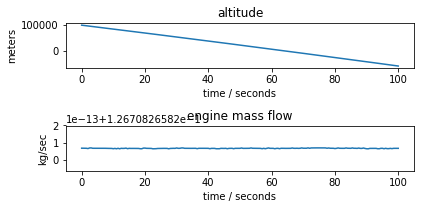

In [0]:
t_f = 100

m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, t_f))
m.h = Var(m.t)
m.u = Var(m.t, domain=NonNegativeReals)

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.ode1 = Constraint(m.t, rule = lambda m, t: m_total*m.a[t] == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

def solve(m):
  
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=200, scheme='forward')
    SolverFactory('ipopt', executable=ipopt_executable).solve(m)
    
    tsim = [t for t in m.t]
    hsim = [m.h[t]() for t in m.t]
    usim = [m.u[t]() for t in m.t]

    plt.subplot(3,1,1)
    plt.plot(tsim, hsim)
    plt.title('altitude')
    plt.xlabel('time / seconds')
    plt.ylabel('meters')

    plt.subplot(3,1,2)
    plt.plot(tsim, usim)
    plt.title('engine mass flow')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')

    plt.tight_layout()

solve(m)

This first attempt at a solution included no specification related to landing on the lunar surface. The solver reported a solution where the engine doesn't fire, and the lunar module crashes into the lunar surface at full speed about 66 seconds after the start of the descent mission.

### Land on the surface, not above or below the surface.

The mission crashed!  It's clear now that we haven't fully specified the desired outcome of the mission.  Let's start by specifying the final condition as being on the surface

$$h(t_f) = 0$$

This condition is implemented in Pyomo by fixing the terminal value of $h$.

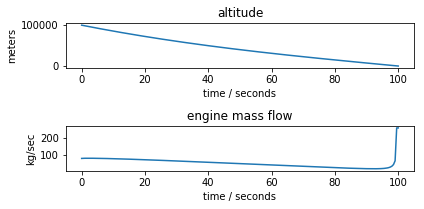

In [0]:
t_f = 100

m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, t_f))
m.h = Var(m.t)
m.u = Var(m.t, domain=NonNegativeReals)

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.ode1 = Constraint(m.t, rule = lambda m, t: m_total*m.a[t] == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

m.h[t_f].fix(0)    # land on surface

solve(m)

The descent mission now finishes the descent at the lunar surface, but unfortunately arrives with sufficient velocity to still be considered a crash.

### Make that a soft landing.

To ensure a soft landing, we also need to specify a terminal velocity.  The terminal conditions are now

\begin{align*}
h(t_f) & = 0 \\
v(t_f) & = 0
\end{align*}

These conditions are implement by fixing terminal values of the associated Pyomo variables.

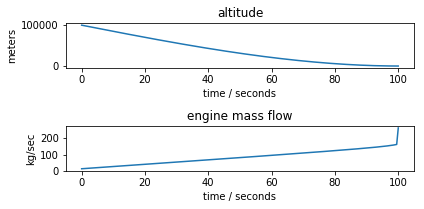

In [0]:
t_f = 100

m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, t_f))
m.h = Var(m.t)
m.u = Var(m.t, domain=NonNegativeReals)

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.ode1 = Constraint(m.t, rule = lambda m, t: m_total*m.a[t] == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

m.h[t_f].fix(0)    # land on surface
m.v[t_f].fix(0)    # soft landing

solve(m)

The lunar module now is now successfully landing on the lunar surface, but the fuel flow requirement exceeds the maximum capacity of the descent engine.

### Restrict fuel flow to engine capacity.

The next step is establish constraints on the control action by limiting fuel flow to the mass flow limits of the descent engine.

$$ 0 \leq u(t) \leq u_{max}$$

Since less thrust is available, we may need to extend the length of the landing mission to find a feasible solution to the optimization problem.

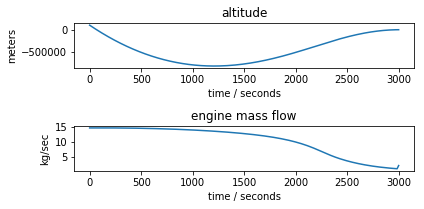

In [0]:
t_f = 3000

m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, t_f))
m.h = Var(m.t)
m.u = Var(m.t, bounds=(0, u_max))

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.ode1 = Constraint(m.t, rule = lambda m, t: m_total*m.a[t] == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

m.h[t_f].fix(0)    # land on surface
m.v[t_f].fix(0)    # soft landing

solve(m)

## Version 2: Rescaled Model

At this point, it's now clear the first version of this model has run into some serious problems:

* The calculated trajectory takes us through a crash landing and trip through the interior of the moon. 
* The engine thrust never goes to zero, even when the lander is at zero velocity and on the surface. The reason is that the model doesn't account for the reaction force of the surface on the lander. So the lander is really just hoovering rather than landing.
* There is no obvious means of estimating the time required for the mission. 

Let's begin with the last issue. We will introduce an additional decision variable $T$ denoting the length of the mission. Time is then rescaled as

$$\tau = \frac{t}{T}\quad\implies\quad t =\tau T$$

The differential equation model then becomes

\begin{align*}
\frac{m}{T^2}\frac{d^2h}{d\tau^2} & = - m g + v_eu \\
\end{align*}

The net result is that an additional variable, $T$, denoting the duration of the descent mission has been introduced into the optimization problem.

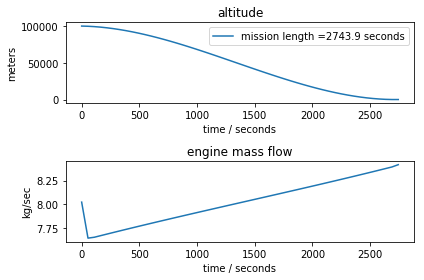

In [0]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.h = Var(m.t)
m.u = Var(m.t, bounds=(0, u_max))
m.T = Var(domain=NonNegativeReals)

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.ode1 = Constraint(m.t, rule = lambda m, t: 
    m_total*m.a[t]/m.T**2 == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

m.h[1].fix(0)    # land on surface
m.v[1].fix(0)    # soft landing

def solve(m):
  
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, method='forward')
    SolverFactory('ipopt', executable=ipopt_executable).solve(m)
    
    tsim = [t*m.T() for t in m.t]
    hsim = [m.h[t]() for t in m.t]
    usim = [m.u[t]() for t in m.t]

    plt.subplot(2,1,1)
    plt.plot(tsim, hsim)
    plt.title('altitude')
    plt.xlabel('time / seconds')
    plt.ylabel('meters')
    plt.legend(['mission length =' + str(round(m.T(),1)) + ' seconds'])

    plt.subplot(2,1,2)
    plt.plot(tsim, usim)
    plt.title('engine mass flow')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')

    plt.tight_layout()

solve(m)

### How much fuel is burned?

Fuel consumption can be calculated as

\begin{align*}
\mbox{fuel consumed} & = \int_0^T u(t)\,dt  = T \int_0^1u(\tau)\,d\tau
\end{align*}

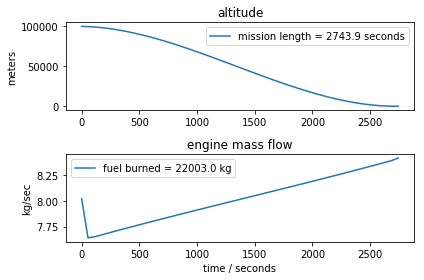

In [0]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.h = Var(m.t)
m.u = Var(m.t, bounds=(0, u_max))
m.T = Var(domain=NonNegativeReals)

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.fuel = Integral(m.t, wrt=m.t, rule = lambda m, t: m.u[t]*m.T)

m.ode1 = Constraint(m.t, rule = lambda m, t: 
    m_total*m.a[t]/m.T**2 == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

m.h[1].fix(0)    # land on surface
m.v[1].fix(0)    # soft landing

def solve(m):
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, method='forward')
    SolverFactory('ipopt', executable=ipopt_executable).solve(m)
    
    tsim = [t*m.T() for t in m.t]
    hsim = [m.h[t]() for t in m.t]
    usim = [m.u[t]() for t in m.t]

    plt.subplot(2,1,1)
    plt.plot(tsim, hsim)
    plt.title('altitude')
    plt.ylabel('meters')
    plt.legend(['mission length = ' + str(round(m.T(),1)) + ' seconds'])

    plt.subplot(2,1,2)
    plt.plot(tsim, usim)
    plt.title('engine mass flow')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')
    plt.legend(['fuel burned = ' + str(round(m.fuel(),1)) + ' kg'])

    plt.tight_layout()

solve(m)

### Minimize fuel consumption.

$$\min_{u(\tau), T} T\int_0^1 u(\tau)\, d\tau$$

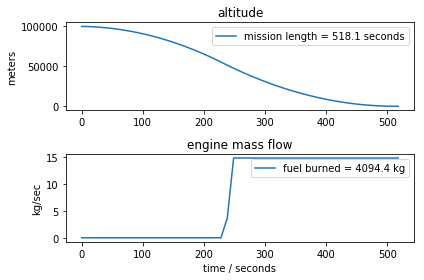

In [0]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.h = Var(m.t)
m.u = Var(m.t, bounds=(0, u_max))
m.T = Var(domain=NonNegativeReals)

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)

m.fuel = Integral(m.t, wrt=m.t, rule = lambda m, t: m.u[t]*m.T)
m.obj = Objective(expr=m.fuel, sense=minimize)

m.ode1 = Constraint(m.t, rule = lambda m, t: m_total*m.a[t]/m.T**2 == -m_total*g + v_exhaust*m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)

m.h[1].fix(0)    # land on surface
m.v[1].fix(0)    # soft landing

solve(m)

## Version 3: Rocket Model

The first version of the rocket model has run into a serious problem because it appears not to provide enough mass flow to the engine to prevent a crash landing. But that may be an artifact of the assumption of constant mass. For Apollo 11 Lunar Module, for example, the fuel in the descent engine comprises more than 50% of the total mass of the lander.

For the second version of the rocket model, we augment the model with a mass balance for fuel. This yields 

\begin{align*}
\frac{m(t)}{T^2}\frac{d^2h}{d\tau^2} & = - m(t)g + v_eu \\
\\
\frac{1}{T}\frac{dm}{d\tau} & = -u
\end{align*}

At this point we need to worry about nonsensical answers to the optimization for minimum fuel. For this purpose we add upper and lower bounds on $T$ that should restrict the solver to meaningful solutions.

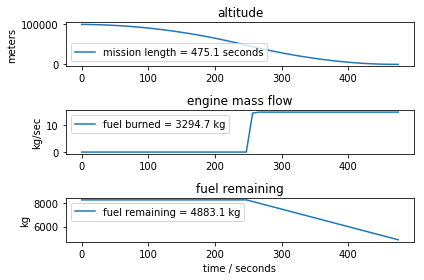

In [0]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.h = Var(m.t, domain=NonNegativeReals)
m.m = Var(m.t)
m.u = Var(m.t, bounds=(0, u_max))
m.T = Var(bounds=(50,3000))

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)
m.mdot = DerivativeVar(m.m, wrt=m.t)

m.fuel = Integral(m.t, wrt=m.t, rule = lambda m, t: m.u[t]*m.T)
m.obj = Objective(expr=m.fuel, sense=minimize)

m.ode1 = Constraint(m.t, rule = lambda m, t: m.m[t]*m.a[t]/m.T**2 == -m.m[t]*g + v_exhaust*m.u[t])
m.ode2 = Constraint(m.t, rule = lambda m, t: m.mdot[t]/m.T == -m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)
m.m[0].fix(m_total)

m.h[1].fix(0)    # land on surface
m.v[1].fix(0)    # soft landing

def solve(m):
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, method='forward')
    SolverFactory('ipopt', executable=ipopt_executable).solve(m)
    
    m_nonfuel = m_ascent_dry + m_ascent_fuel + m_descent_dry
    
    tsim = [t*m.T() for t in m.t]
    hsim = [m.h[t]() for t in m.t]
    usim = [m.u[t]() for t in m.t]
    fsim = [m.m[t]() - m_nonfuel for t in m.t]

    plt.subplot(3,1,1)
    plt.plot(tsim, hsim)
    plt.title('altitude')
    plt.ylabel('meters')
    plt.legend(['mission length = ' + str(round(m.T(),1)) + ' seconds'])

    plt.subplot(3,1,2)
    plt.plot(tsim, usim)
    plt.title('engine mass flow')
    plt.ylabel('kg/sec')
    plt.legend(['fuel burned = ' + str(round(m.fuel(),1)) + ' kg'])

    plt.subplot(3,1,3)
    plt.plot(tsim, fsim)
    plt.title('fuel remaining')
    plt.xlabel('time / seconds')
    plt.ylabel('kg')
    plt.legend(['fuel remaining = ' + str(round(fsim[-1],2)) + ' kg'])

    plt.tight_layout()

solve(m)

<!--NAVIGATION-->
< [Path Planning for a Simple Car](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.03-Path-Planning-for-a-Simple-Car.ipynb) | [Contents](toc.ipynb) | [Parameter Estimation](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/07.00-Parameter-Estimation.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.04-Soft-Landing-Apollo-11-on-the-Moon.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>